# Visualize Label Distribution

Learn how to visualize and compare partitioned datasets when applying different `Partitioner`s or parameters.

If you partition datasets to simulate heterogeneity through label skew and/or size skew, you can now effortlessly visualize the partitioned dataset using `flwr-datasets`.

All the described visualization functions are compatible with all ``Partitioner`` you can find in
[flwr_datasets.partitioner](https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.html#module-flwr_datasets.partitioner)


## Install Flower Datasets

In [1]:
! pip install -q "flwr-datasets[vision]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu1

## Plot Label Distribution

### Bar plot

Let's visualize the result of `DirichletPartitioner`.
We will create a `FederatedDataset` and assign `DirichletPartitioner` to the `train` split:

In [52]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions


fds = FederatedDataset(
    dataset="albertvillanova/medmnist-v2",
    subset='dermamnist',
    partitioners={
        "train": DirichletPartitioner(
            num_partitions=10,
            partition_by="label",
            alpha=0.3,
            seed=42,
            min_partition_size=0,
        ),
    },
)

partitioner = fds.partitioners["train"]

Once we have the partitioner with the dataset assigned, we are ready to pass it to the plotting function:

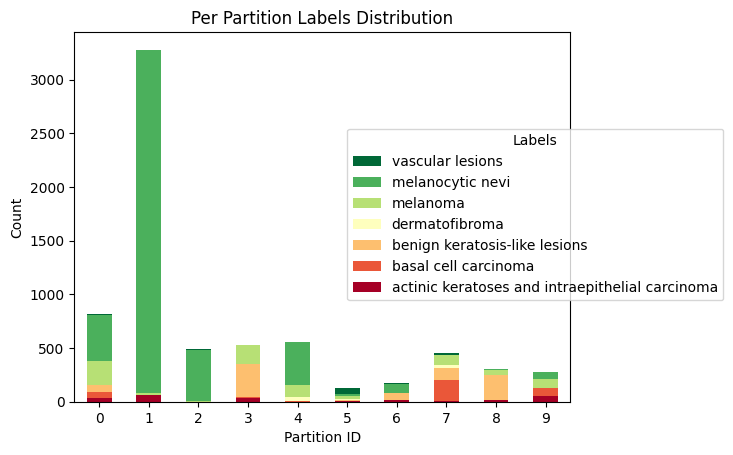

In [53]:
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)

You can configure many details directly using the function parameters. The ones that can interest you the most are:

* `size_unit` to have the sizes normalized such that they sum up to 1 and express the fraction of the data in each partition,
* `legend` and `verbose_labels` in case the dataset has more descriptive names and not numbers,
* `cmap` to change the values of the bars (for an overview of the available colors, have a look at [link](https://matplotlib.org/stable/users/explain/colors/colormaps.html); check out `cmap="tab20b"`)

 And for even greater control, you can specify `plot_kwargs` and `legend_kwargs` as `Dict`, which will be further passed to the `plot` and `legend` functions.

You can also inspect the exact numbers that were used to create this plot. Three objects are returned (see reference [here](https://flower.ai/docs/datasets/ref-api/flwr_datasets.visualization.plot_label_distributions.html#flwr_datasets.visualization.plot_label_distributions)). Let's inspect the returned DataFrame.

In [37]:
df

,0,1,2,3,4,5,6,7,8
Partition ID,,,,,,,,,
0,1351,306,433,69,4616,1107,234,2189,2082
1,2152,2493,3815,701,1031,4,1973,300,86
2,15,45,1052,234,30,160,334,1058,77
3,1270,205,297,5591,877,4333,989,1717,657
4,27,1206,2979,2626,133,12,876,1168,300
5,231,4178,281,53,277,301,2921,421,46
6,754,389,138,13,21,1098,19,39,6015
7,523,328,1325,815,64,1709,29,995,234
8,1791,254,25,81,240,3456,463,650,2721


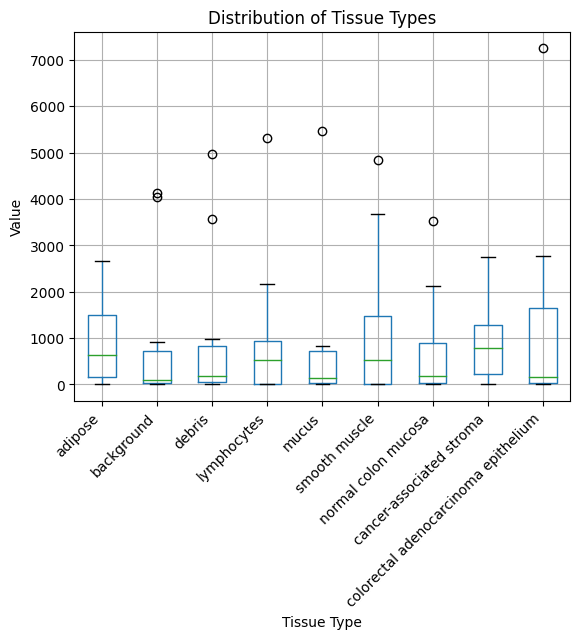

In [17]:
# @title Distribution of Tissue Types

import matplotlib.pyplot as plt

df.boxplot(column=['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium'])
plt.xlabel('Tissue Type')
plt.ylabel('Value')
plt.title('Distribution of Tissue Types')
_ = plt.xticks(rotation=45, ha='right')

Each row represents a unique partition ID, and the columns represent unique labels (either in the verbose version if `verbose_labels=True` or typically `int` values otherwise, representing the partition IDs).
That you can index the DataFrame `df[partition_id, label_id]` to get the number of samples in `partition_id` for the specified `label_id.`

In [13]:
df.loc[4, "bird"]

KeyError: 'bird'

Let's see a plot with `size_unit="percent"`, which is another excellent way to understand the partitions. In this mode, the number of datapoints for each class in a given partition are normalized, so they sum up to 100.

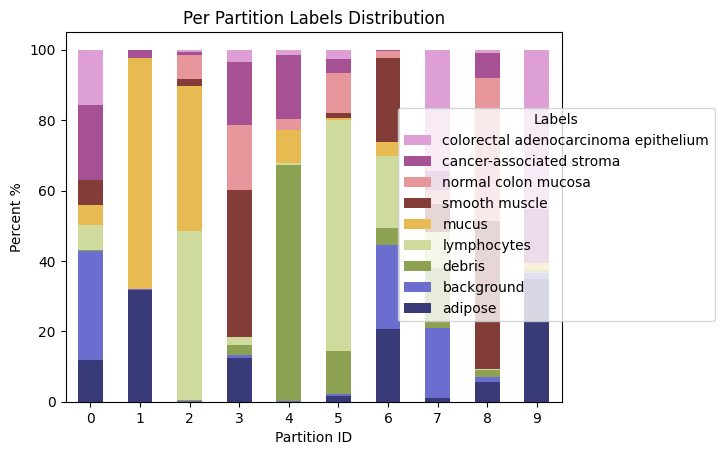

In [14]:
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="percent",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    cmap="tab20b",
    title="Per Partition Labels Distribution",
)

### Heatmap

You might want to visualize the results of partitioning as a heatmap, which can be especially useful for binary labels. Here's how:

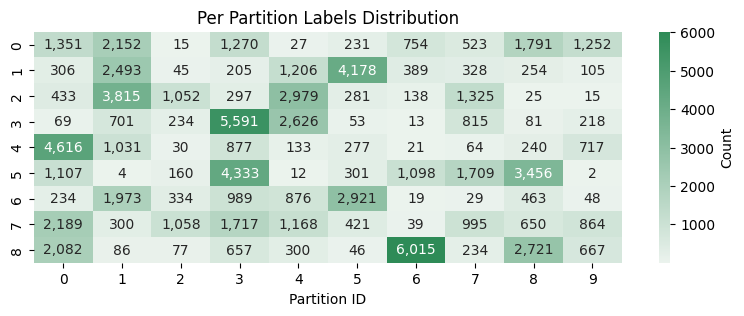

In [21]:
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="heatmap",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=False,
    title="Per Partition Labels Distribution",
    plot_kwargs={"annot": True},
)

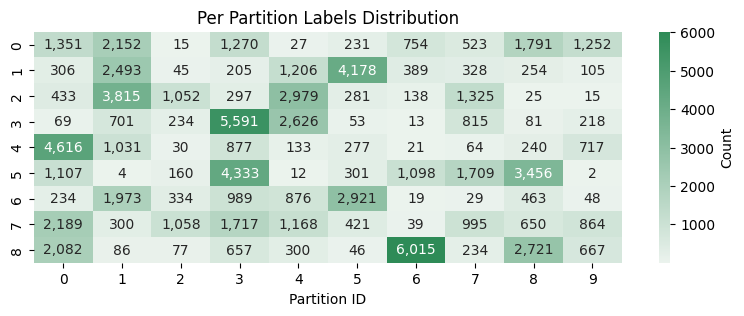

In [22]:
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="heatmap",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=False,
    title="Per Partition Labels Distribution",
    plot_kwargs={"annot": True},
)

# Save the plot as a PDF file
fig.savefig("label_distributions2.pdf", bbox_inches='tight')

Note: we used the `plot_kwargs={"annot": True}` to add the number directly to the plot.

If you are a `pandas` fan, then you might be interested that a similar heatmap can be created with the DataFrame object for visualization in jupyter notebook:

In [23]:
df.style.background_gradient(axis=None, cmap="Greens", vmin=0)

,0,1,2,3,4,5,6,7,8
Partition ID,,,,,,,,,
0,1351,306,433,69,4616,1107,234,2189,2082
1,2152,2493,3815,701,1031,4,1973,300,86
2,15,45,1052,234,30,160,334,1058,77
3,1270,205,297,5591,877,4333,989,1717,657
4,27,1206,2979,2626,133,12,876,1168,300
5,231,4178,281,53,277,301,2921,421,46
6,754,389,138,13,21,1098,19,39,6015
7,523,328,1325,815,64,1709,29,995,234
8,1791,254,25,81,240,3456,463,650,2721


## Plot Comparison of Label Distributions

Now, once you know how to visualize a single partitioned dataset, you'll learn how to compare a few of them on a single plot.

Let's compare:

- IidPartitioner,
- DirichletPartitioner,
- ShardPartitioner
still using the `cifar10` dataset.

We need to create a list of partitioners. Each partitioner needs to have a dataset assigned to it (it does not have to be the same dataset so you can also compare the same partitioning on different datasets).

In [25]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import (
    IidPartitioner,
    DirichletPartitioner,
    ShardPartitioner,
)

partitioner_list = []
title_list = ["IidPartitioner", "DirichletPartitioner", "ShardPartitioner"]

## IidPartitioner
fds = FederatedDataset(
    dataset="albertvillanova/medmnist-v2",
    subset='pathmnist',
    partitioners={
        "train": IidPartitioner(num_partitions=10),
    },
)
partitioner_list.append(fds.partitioners["train"])

## DirichletPartitioner
fds = FederatedDataset(
        dataset="albertvillanova/medmnist-v2",
    subset='pathmnist',
    partitioners={
        "train": DirichletPartitioner(
            num_partitions=10,
            partition_by="label",
            alpha=1.0,
            min_partition_size=0,
        ),
    },
)
partitioner_list.append(fds.partitioners["train"])

## ShardPartitioner
fds = FederatedDataset(
        dataset="albertvillanova/medmnist-v2",
    subset='pathmnist',
    partitioners={
        "train": ShardPartitioner(
            num_partitions=10, partition_by="label", num_shards_per_partition=2
        )
    },
)
partitioner_list.append(fds.partitioners["train"])

/usr/local/lib/python3.10/dist-packages/flwr_datasets/utils.py:103: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps']. Given: albertvillanova/medmnist-v2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for albertvillanova/medmnist-v2 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/albertvillanova/medmnist-v2
You can avoid this message in future by passing the argument `trust_remote_co

Now let's visualize them side by side

/usr/local/lib/python3.10/dist-packages/flwr_datasets/visualization/comparison_label_distribution.py:213: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


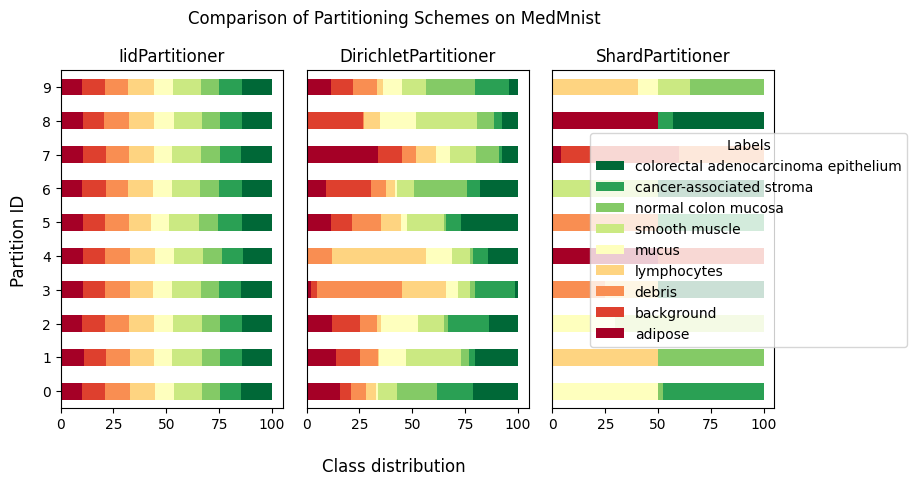

In [27]:
from flwr_datasets.visualization import plot_comparison_label_distribution

fig, axes, df_list = plot_comparison_label_distribution(
    partitioner_list=partitioner_list,
    label_name="label",
    subtitle="Comparison of Partitioning Schemes on MedMnist",
    titles=title_list,
    legend=True,
    verbose_labels=True,
)

## Bonus: Natural Id Dataset

Nothing stops you from using the `NaturalIdPartitioner` to visualize a dataset with the `id` in it and does not need the artificial partitioning but has the pre-existing partitions. For that dataset, we use `NaturalIdPartitioner`. Let's look at the `speech-commands` dataset that has `speaker_id`, and there are quite a few speakers; therefore, we will show only the first 20 partitions. And since we have quite a few different labels, let's specify `legend_kwargs={"ncols": 2}` to display them in two columns (we will also shift the legend slightly to the right).

You'll be using the [Google SpeechCommands](https://huggingface.co/datasets/google/speech_commands) dataset, which is a speech-based dataset. For this, you'll need to install the `"audio"` extension for Flower Datasets. It can be easily done like this:

In [ ]:
! pip install -q "flwr-datasets[audio]"

With everything ready, let's visualize the partitions for a naturally partitioned dataset.

/usr/local/lib/python3.10/dist-packages/flwr_datasets/utils.py:103: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps']. Given: google/speech_commands.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for google/speech_commands contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/speech_commands
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passi

Generating train split:   0%|          | 0/51093 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6799 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3081 [00:00<?, ? examples/s]

Generating partition_id_to_indices: 51093it [00:00, 1380894.10it/s]


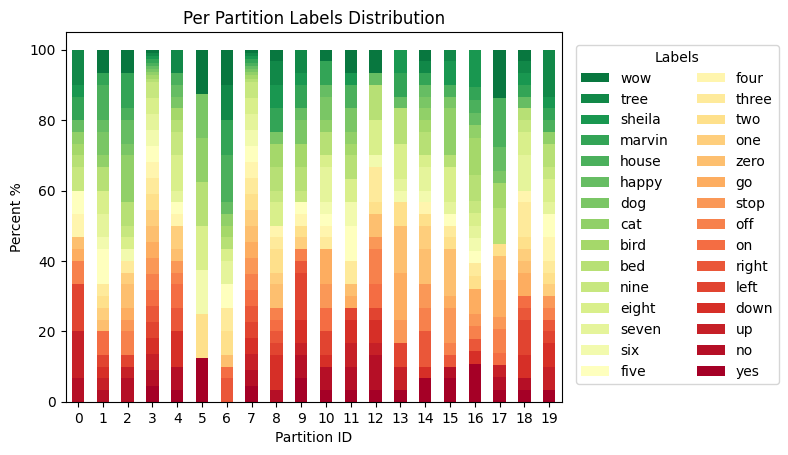

In [30]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import NaturalIdPartitioner
from flwr_datasets.visualization import plot_label_distributions


fds = FederatedDataset(
    dataset="google/speech_commands",
    subset="v0.01",
    partitioners={
        "train": NaturalIdPartitioner(
            partition_by="speaker_id",
        ),
    },
)

partitioner = fds.partitioners["train"]

fix, ax, df = plot_label_distributions(
    partitioner=partitioner,
    label_name="label",
    max_num_partitions=20,
    plot_type="bar",
    size_unit="percent",
    partition_id_axis="x",
    legend=True,
    title="Per Partition Labels Distribution",
    verbose_labels=True,
    legend_kwargs={"ncols": 2, "bbox_to_anchor": (1.25, 0.5)},
)

## More resources

If you are looking for more resources, feel free to check:

* `flwr-dataset` documentation
    * [plot_label_distributions](https://flower.ai/docs/datasets/ref-api/flwr_datasets.visualization.plot_label_distributions.html#flwr_datasets.visualization.plot_label_distributions)
    * [plot_comparison_label_distribution](https://flower.ai/docs/datasets/ref-api/flwr_datasets.visualization.plot_comparison_label_distribution.html#flwr_datasets.visualization.plot_comparison_label_distribution)
* if you want to do any custom modification of the returned plots
    * [matplotlib](https://matplotlib.org/)
    * [seaborn](https://seaborn.pydata.org/)
    * or plot directly using pandas object [pd.DataFrame.plot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)


This was the last tutorial.

Previous tutorials:

* [Quickstart Basics](https://flower.ai/docs/datasets/tutorial-quickstart.html)

* [Use Partitioners](https://flower.ai/docs/datasets/tutorial-use-partitioners.html)